In [6]:
import numpy as np
from PIL import Image
from PIL import ImageShow
import time
import torch
from torch.nn import Module, Conv2d, ReLU, MaxPool2d, Flatten, Linear, CrossEntropyLoss, Sequential
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

CLASSES = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class0 = CLASSES.index('cat')
class1 = CLASSES.index('dog')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Model(Module):
    def __init__(self, n_outputs):
        super().__init__()
        self.layers = Sequential(
            Conv2d(3, 32, 3),
            ReLU(),
            MaxPool2d(2, 2),
            Conv2d(32, 64, 3),
            ReLU(),
            MaxPool2d(2, 2),
            Conv2d(64, 32, 4),
            ReLU(),
            Flatten(),
            Linear(288, 64),
            ReLU(),
            Linear(64, n_outputs),
        )

    def forward(self, x):
        return self.layers(x)

target_map = {
    class0: [1.0,0.0],
    class1: [0.0,1.0],
}
ind_test_target_map = {
    class0: 0,
    class1: 1,
}
neutral = [0.5,0.5]
    
train_orig = CIFAR10('data', train=True, transform=ToTensor(), target_transform=lambda c:torch.tensor(target_map.get(c,neutral)), download=True)
indices = [i for i,t in enumerate(train_orig.targets) if t in target_map]
train_data = Subset(train_orig, indices)

test_data = CIFAR10('data', train=False, transform=ToTensor(), download=True)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

ind_test_orig = CIFAR10('data', train=False, transform=ToTensor(), target_transform=lambda c:torch.tensor(ind_test_target_map.get(c,neutral)), download=True)
indices = [i for i,t in enumerate(ind_test_orig.targets) if t in target_map]
ind_test_data = Subset(ind_test_orig, indices)
ind_test_dataloader = DataLoader(ind_test_data, batch_size=64, shuffle=False)

model = Model(2).to(device)
opt = torch.optim.Adam(model.parameters(), weight_decay=0.003)
loss = CrossEntropyLoss()
max_epochs = 30
max_minutes = 5

start_time = time.monotonic()

print(device)

# Training
for epoch in range(max_epochs):
    
    running_loss = torch.zeros(()).to(device)
    running_acc = torch.zeros(()).to(device)
    running_n = 0
    for X,targets in train_dataloader:
        X = X.to(device)
        targets = targets.to(device)
        opt.zero_grad()
        outputs = model(X)

        loss_value = loss(outputs, targets)
        loss_value.backward()
        opt.step()
        running_loss += loss_value.detach()
        running_n += X.shape[0]
        
        preds = outputs.detach().argmax(dim=1)
        running_acc += (preds == targets.argmax(dim=1)).sum()
    print('Epoch', epoch, '   Loss', running_loss.item() / running_n, '    TAcc', running_acc.item() / running_n)
#    print(outputs.detach())

    if time.monotonic() - start_time > max_minutes * 60:
        print("Run out of time!")
        break
        
    with torch.no_grad():
        running_acc = torch.zeros(()).to(device)
        running_n = 0
        n_of_0 = torch.zeros(()).to(device)
        n_of_1 = torch.zeros(()).to(device)
        for X,targets in ind_test_dataloader:
            X = X.to(device)
            targets = targets.to(device)
            
            outputs = model(X)
            preds = outputs.argmax(dim=1)
            running_acc += (preds == targets).sum()
            running_n += X.shape[0]
            
            n_of_0 += (preds == 0).sum()
            n_of_1 += (preds == 1).sum()
        print('     Accuracy', running_acc.item() / running_n, f'n_{class0}', n_of_0.item(), f'n_{class1}', n_of_1.item())
print('Time taken', time.monotonic() - start_time, ' seconds')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 0    Loss 0.010721488952636719     TAcc 0.5545
     Accuracy 0.5825 n_3 995.0 n_5 1005.0
Epoch 1    Loss 0.010443961334228516     TAcc 0.5983
     Accuracy 0.6065 n_3 943.0 n_5 1057.0
Epoch 2    Loss 0.010133765411376953     TAcc 0.6249
     Accuracy 0.632 n_3 848.0 n_5 1152.0
Epoch 3    Loss 0.009909548187255859     TAcc 0.6458
     Accuracy 0.663 n_3 1260.0 n_5 740.0
Epoch 4    Loss 0.00971396484375     TAcc 0.661
     Accuracy 0.6525 n_3 1135.0 n_5 865.0
Epoch 5    Loss 0.009504921722412109     TAcc 0.6702
     Accuracy 0.6705 n_3 1013.0 n_5 987.0
Epoch 6    Loss 0.009276242828369141     TAcc 0.6846
     Accuracy 0.702 n_3 1028.0 n_5 972.0
Epoch 7    Loss 0.008994326782226562     TAcc 0.7001
     Accuracy 0.7 n_3 976.0 n_5 1024.0
Epoch 8    Loss 0.008675514221191406     TAcc 0.7142
     Accuracy 0.713 n_3 896.0 n_5 1104.0
Epoch 9    Loss 0.008467442321777343

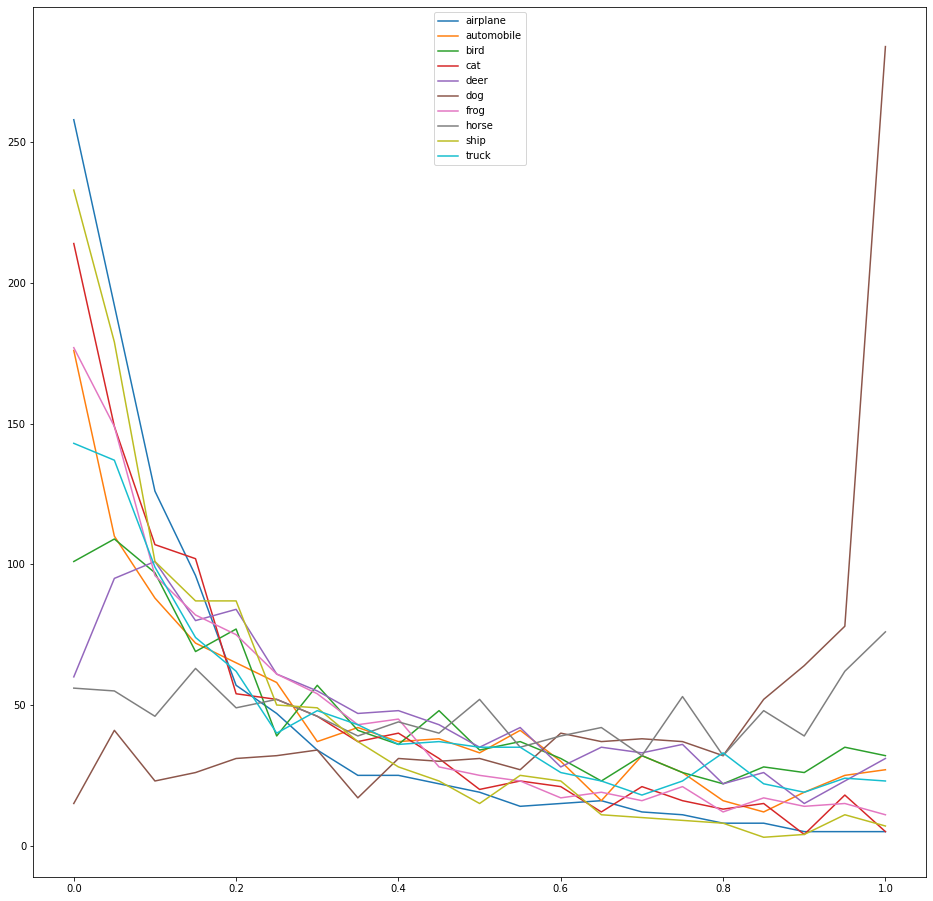

In [7]:
from matplotlib import pyplot as plt

with torch.no_grad():
    probs = np.zeros((len(test_data),))
    targets = np.zeros((len(test_data),))
    i = 0
    for X,y in test_dataloader:
        X = X.to(device)
        j = i + X.shape[0]
        probs[i:j] = model(X).softmax(dim=1)[:,1].to('cpu').numpy()
        targets[i:j] = y
        i = j

    plt.rcParams['figure.figsize'] = [16, 16]
    for i,label in enumerate(CLASSES):
        samples = probs.compress(targets==i, axis=0)
        h, _ = np.histogram(samples, bins=21, range=(0,1))
        plt.plot(np.arange(21)/20, h, label=label)
    plt.legend()

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

with torch.no_grad():
    scores = np.zeros((len(test_data),))
    targets = np.zeros((len(test_data),))
    oods = np.zeros((len(test_data),), 'bool')
    i = 0
    for X,y in test_dataloader:
        X = X.to(device)
        j = i + X.shape[0]
        outputs = model(X).softmax(dim=1)[:,1].to('cpu').numpy()
        scores[i:j] = np.minimum(outputs, 1 - outputs)
        targets[i:j] = y
        oods[i:j] = (y != class0) & (y != class1)
        i = j

    plt.rcParams['figure.figsize'] = [8, 8]
    for i,label in enumerate(CLASSES):
        if i == class0 or i == class1:
            # ROC curve doesn't make sense for the in-distribution classes
            plt.plot([], [], label=label)
        else:
            keep = (targets == i) | ~oods
            y_true = oods.compress(keep, axis=0)
            y_score = scores.compress(keep, axis=0)
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            plt.plot(fpr, tpr, label=label)
    plt.legend()